**Universidad de Ingeniería  y Tecnología (UTEC)**  
Lima, Peru

# Tema de Laboratorio: Classification

**Alumnos**:

1. Leonardo Matías Candio Ormeño

1. Jeffry Hilario Quintana

1. Mauricio Alvarez Julca

## Find a publicly available dataset between 3 and 10 classes, with no more than 1000000 data points, and no less than 1000 data points. You can not use MNIST, but can use derivatives (you can use datasets other than images)

We chose to use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset for this project  

## Define your Training Set, Your Validation Set, and Testing Set. How will you partition your data? What is the percentile split? (Example: 80% Training, 10% Validation, 10% Testing) Why did you pick this split

CIFAR-10 provides 50000 specific training images (5000 per class) and 10000 testing images (1000 per class). Each image has $32*32*3$ features, so we chose to reduce the complexity of the data we train our model on. The amount of classes was reduced to 3 (airplane, truck and dog). Therefore, the amount of data was also reduced to 12000 training images, 3000 validation images and 3000 testing images. This means that the split is: 66.66% Training, 16.66% Validation, 16.66% Testing.


In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.linear_model import LogisticRegression

validation_per_label = 1000

data_labels = {
    0: "airplane",
    1: "truck",
    2: "dog",
}


In [3]:
def get_sets():
    def load_img(_img_label, _img_position, _img_type):
        data_path = "../data"
        return np.array(Image.open(
            f'{data_path}/{"train" if _img_type in ["validation", "train"] else "test"}/{data_labels[_img_label]}/{_img_position:04d}.png')).flatten()

    validation = {_label: set(np.random.permutation(np.arange(1, 5001))[:validation_per_label].flatten()) for _label
                  in range(3)}
    train = {_label: {_img for _img in [i for i in range(1, 5001)] if _img not in validation[_label]} for _label in
             range(3)}
    test = {_label: {_img for _img in range(1, 1001)} for _label in range(3)}

    _validation_set = []
    _train_set = []
    _test_set = []

    for key, value in validation.items():
        for image in value:
            _validation_set.append((load_img(key, image, "validation"), key))

    for key, value in train.items():
        for image in value:
            _train_set.append((load_img(key, image, "train"), key))

    for key, value in test.items():
        for image in value:
            _test_set.append((load_img(key, image, "test"), key))

    random.shuffle(_validation_set)
    random.shuffle(_train_set)
    random.shuffle(_test_set)

    _train_images, _train_labels = zip(*_train_set)
    _validation_images, _validation_labels = zip(*_validation_set)
    _test_images, _test_labels = zip(*_test_set)

    return np.asarray(_train_images), np.asarray(_train_labels), np.asarray(_validation_images), np.asarray(
        _validation_labels), np.asarray(_test_images), np.asarray(_test_labels)


train_images, train_labels, validation_images, validation_labels, test_images, test_labels = get_sets()

Regression without regularization

In [5]:
model = LogisticRegression(n_jobs=2, max_iter=1000, solver='saga', multi_class='multinomial')

In [89]:
model.fit(train_images, train_labels)

/Users/leonardocandio/.conda/envs/lab2/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=2,
                   solver='saga')

In [90]:

predicted_labels = model.predict(validation_images)

In [91]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

accuracy_score(validation_labels, predicted_labels)

0.706

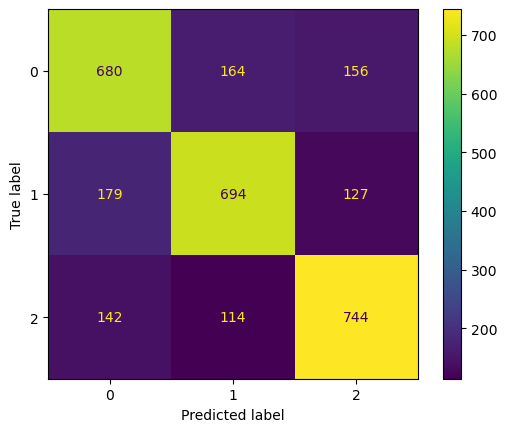

In [92]:
cm = confusion_matrix(validation_labels, predicted_labels)
ConfusionMatrixDisplay(cm).plot()

## Hacer una regularizacion del tipo L0, L1 o L2 sobre la regresion logistica multi-clase sobre las clases previas. Re-plotear las matrices de confusion. Que ha cambiado? Las matrices de confusion se ven mejor o peor? Por que?

In [4]:
#Model regularization L1
model_l1 = LogisticRegression(penalty='l1',n_jobs=2, max_iter=1000, solver='saga', multi_class='multinomial')

In [6]:
#Model L1 fit
model_l1.fit(train_images, train_labels)

c:\Users\JEFF QUINTANA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial', n_jobs=2,
                   penalty='l1', solver='saga')

In [7]:
#Model L1 training
predicted_labels_l1 = model_l1.predict(validation_images)

In [8]:
#Model Accuracy
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

accuracy_score(validation_labels, predicted_labels_l1)

0.7123333333333334

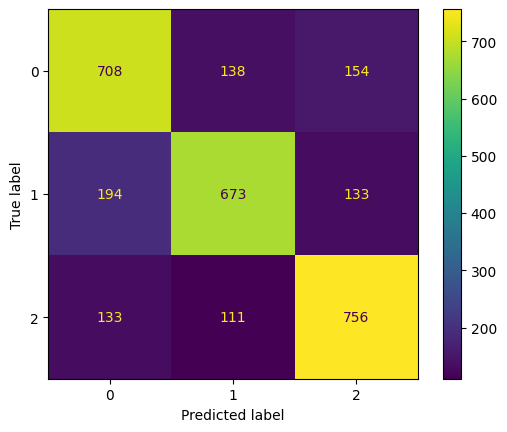

In [10]:
#Model Confusion Display
cm_l1 = confusion_matrix(validation_labels, predicted_labels_l1)
ConfusionMatrixDisplay(cm_l1).plot()

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

num_folds = 5

kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

cross_validation_accuracy = []
confusion_matrix_array = []

for train_index, test_index in kf.split(train_images):
    # Given the indices for each fold, split the training data into cross validation sets
    X_train, X_test = train_images[train_index], train_images[test_index]
    y_train, y_test = train_labels[train_index], train_labels[test_index]
    # Train the model
    model.fit(X_train, y_train)
    # Evaluate the model with the test given for this fold
    y_pred = model.predict(X_test)
    # Save the accuracy score in the list of scores
    cross_validation_accuracy.append(accuracy_score(y_test, y_pred))
    # Print the confusion matrix for this fold with test given
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrix_array.append(cm)    

    # Use the model to predict train set
    y_pred = model.predict(X_train)
    cross_validation_accuracy.append(accuracy_score(y_train, y_pred))
    cm = confusion_matrix(y_train, y_pred)
    confusion_matrix_array.append(cm)   

    # Use the model to predict validation set
    y_pred = model.predict(validation_images)
    cross_validation_accuracy.append(accuracy_score(validation_labels, y_pred))
    cm = confusion_matrix(validation_labels, y_pred)
    confusion_matrix_array.append(cm)   
        

print(f"Cross validation accuracy: {np.mean(cross_validation_accuracy)}")

c:\Users\Nicolas\Desktop\ML\Lab2\ML-LogisticRegression\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nicolas\Desktop\ML\Lab2\ML-LogisticRegression\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nicolas\Desktop\ML\Lab2\ML-LogisticRegression\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Nicolas\Desktop\ML\Lab2\ML-LogisticRegression\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Cross validation accuracy: 0.744523611111111


c:\Users\Nicolas\Desktop\ML\Lab2\ML-LogisticRegression\venv\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


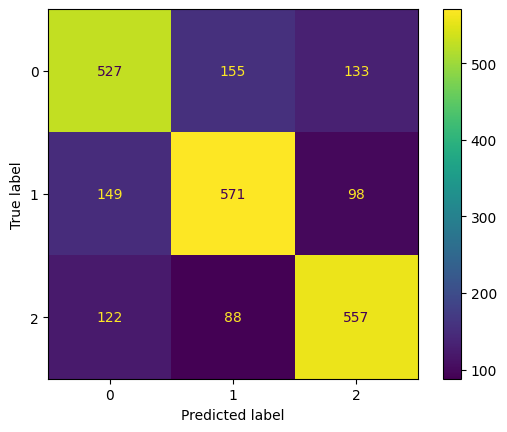

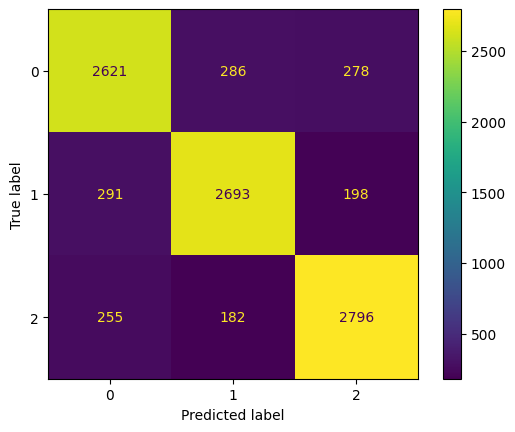

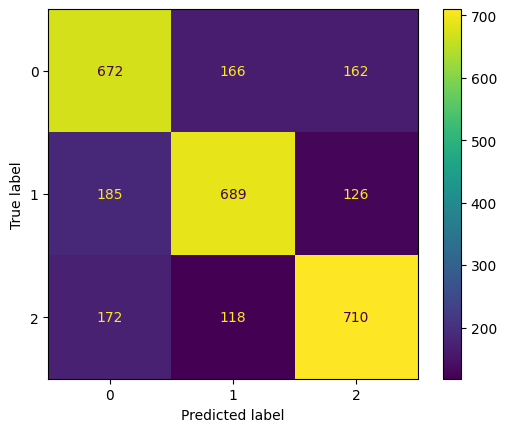

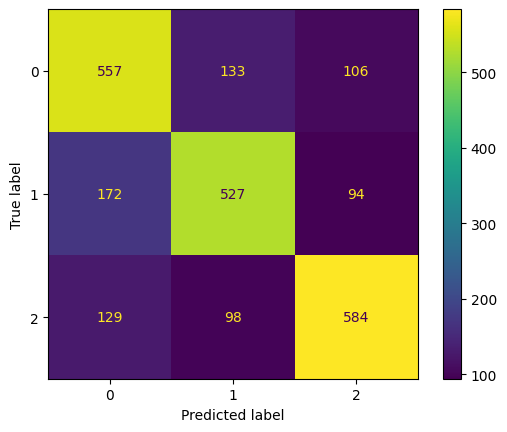

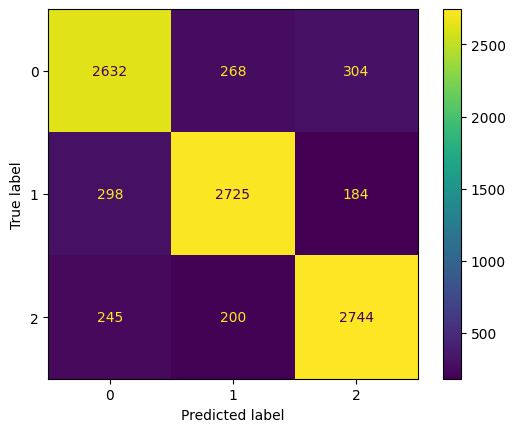

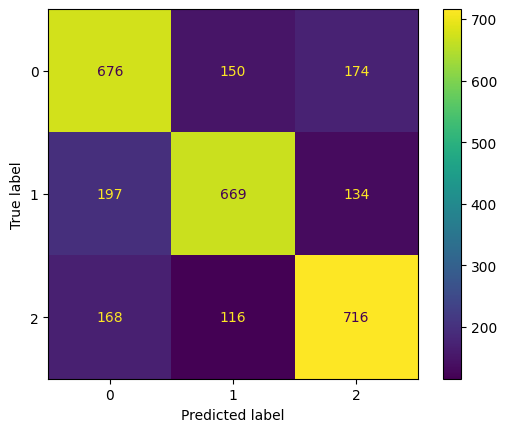

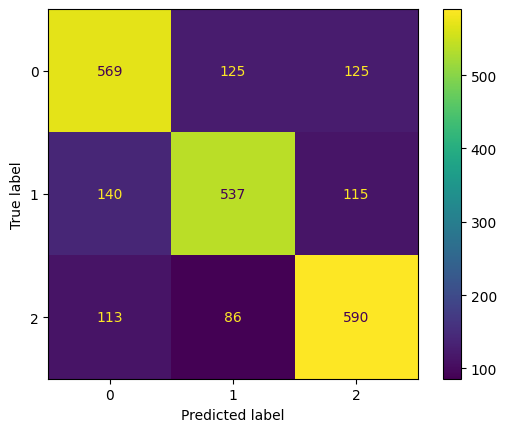

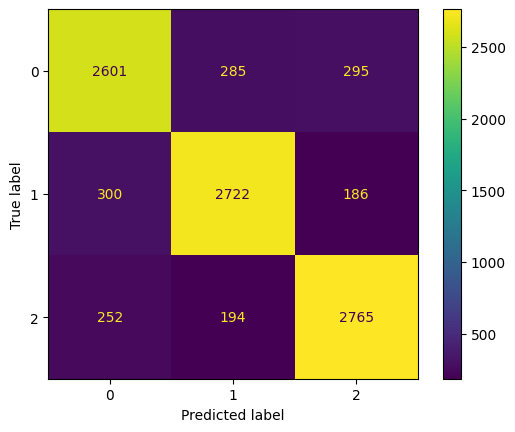

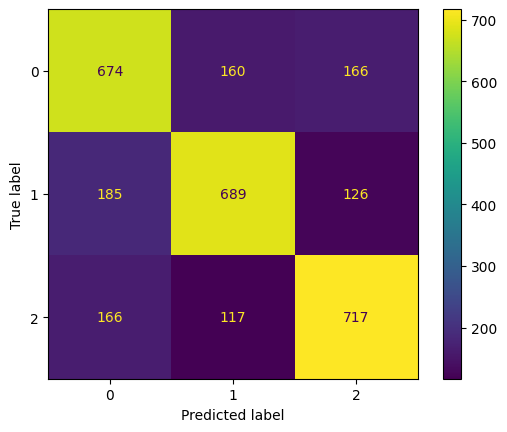

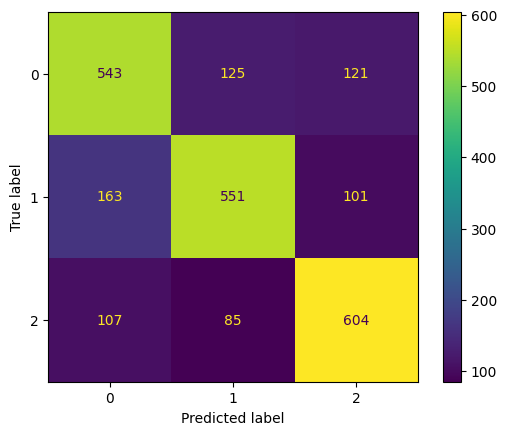

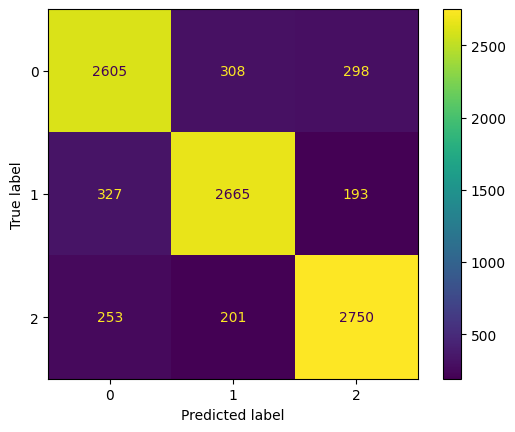

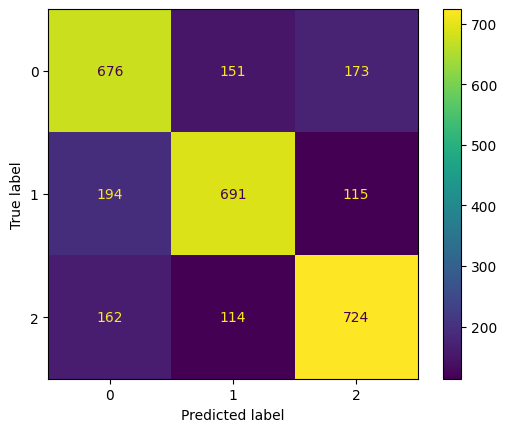

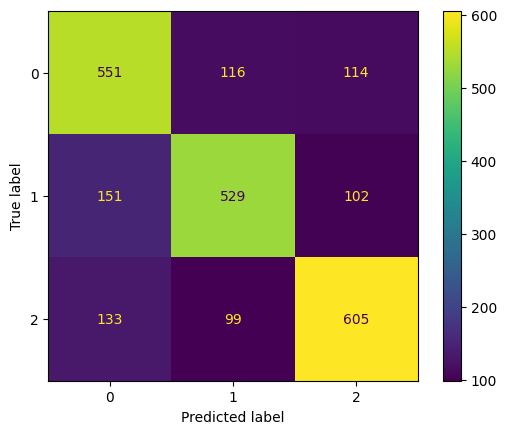

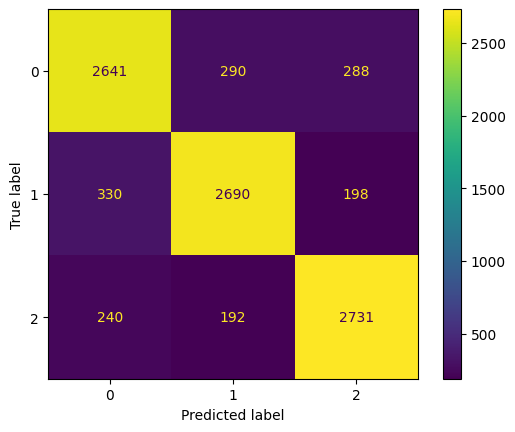

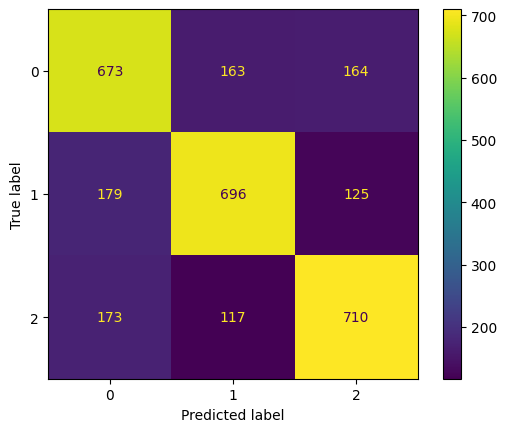

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

for matrix in confusion_matrix_array:
    ConfusionMatrixDisplay(matrix).plot()